In [1]:
import pandas as pd
import pickle
import os
import glob
import re
import string
import emoji
import numpy as np
import matplotlib.pyplot as plt

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, Legend, HoverTool
from bokeh.embed import components
output_notebook()

from bs4 import BeautifulSoup

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

Loading BokehJS ...

In [2]:
def create_dictionaries_of_tweets():
    '''Creates a dictionary of tweets for each politician'''
    
    out_dict = {}
    
    for filename in glob.glob('data/scraped_twitter_profiles/nyc/mayor_election/*.pkl'):
        politician_handle = filename.split('/')[-1].split('_')[0]
        with open(filename, 'rb') as file:    
            tweet_df = pickle.load(file)
            out_dict[politician_handle] = tweet_df['tweet'].drop_duplicates().to_frame()
    return(out_dict)

politician_dict = create_dictionaries_of_tweets()
print(len(politician_dict))

32


In [3]:
#filtering for number of tweets
min_tweets = 500

politician_dict = {key: value for key, value in politician_dict.items() if len(value) > min_tweets}
print(len(politician_dict))

14


In [4]:
def clean_tweet_sentiment_analysis(tweet):
    
    #converts html to text
    tweet = BeautifulSoup(tweet, 'lxml').text
    
    #removes links
    tweet = re.sub(r'http\S+', '', tweet)
    
    #removes twitter usernames
    tweet = re.sub(r'(\s)?@\w+', '', tweet)
    
    return(tweet)

for df in politician_dict.values():
    df['tweet'] = df['tweet'].apply(lambda x: clean_tweet_sentiment_analysis(x))

In [4]:
sentiment_analyzer = SentimentIntensityAnalyzer()

def calc_tweet_sentiment(tweet):    
    
    return sentiment_analyzer.polarity_scores(tweet)['compound']

for df in politician_dict.values():
    df['sentiment'] = df['tweet'].apply(lambda x: calc_tweet_sentiment(x))

In [5]:
custom_stop_words = [word.replace("'", "") for word in stopwords.words('english')] + ['rt', 'amp', 'u', 'w', 'im', 'live', 'must', 'join', 'tune', 'pm', 'et', 
                         'year', 'say', 'get', 'it']

custom_punctuation = '!"#&\'()*+,-./:;<=>?@[\\]^_`{|}~\''

def clean_tweet_tfidf(tweet):
    
    tweet = tweet.lower()
    
    #removing punctuation
    cleaned_tweet = re.sub('[%s]' % re.escape(custom_punctuation), '', tweet)
    
    #removing emojis
    cleaned_tweet = re.sub(emoji.get_emoji_regexp(), r"", cleaned_tweet)
        
    #remove stop words
    cleaned_tweet = ' '.join([item for item in cleaned_tweet.split() if item not in custom_stop_words])
        
    return(cleaned_tweet)

for df in politician_dict.values():
    df['cleaned_tweets'] = df['tweet'].apply(lambda x: clean_tweet_tfidf(x))

In [6]:
#lemmatization function taken from Selva Prabhakaran's post on Machine Learning Plus
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_tweets(tweets):
    #initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    #lemmatize the words
    return [' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(tweet)]) for tweet in tweets]

for df in politician_dict.values():
    df['lemmatized_tweets'] = lemmatize_tweets(df['cleaned_tweets'])


In [14]:
def get_top_words(pol_dict, n_words = 250):
    word_list = []
    
    for df in pol_dict.values():
        tfidf = TfidfVectorizer(stop_words = custom_stop_words, 
                            ngram_range = (1, 3), min_df = 10, max_df = .8, binary = True)
        doc_word = tfidf.fit_transform(df['lemmatized_tweets'])
        
        word_scores = pd.DataFrame(doc_word.toarray(), columns = tfidf.get_feature_names()).sum()
    
        [word_list.append(word) for word in word_scores.nlargest(n_words).index]
        
    return word_list

def calc_word_vectors(df, words):        
    word_scores = []
    for word in words:
        word_df = df[df['lemmatized_tweets'].str.contains(word)]
        word_scores.append(word_df['sentiment'].mean())
    return(word_scores)

top_words = list(set(get_top_words(politician_dict)))

politician_word_scores = [calc_word_vectors(df, top_words) for df in politician_dict.values()]

word_matrix = pd.DataFrame(politician_word_scores, index=list(politician_dict.keys()), columns=top_words).fillna(0)
word_matrix

with open(f'data/word_matrices/nyc_mayor.pkl', 'wb') as file:
        pickle.dump(word_matrix, file)

In [9]:
def create_similarity_matrix(similarity_tool, df_vectors):
        
    similarities = np.zeros((len(df_vectors), len(df_vectors)))
    
    for i in range(len(df_vectors)):
        politician_1 = df_vectors.iloc[i,:].values.reshape(1, -1)
        for j in range(i, len(df_vectors)):
            politician_2 = df_vectors.iloc[j, :].values.reshape(1, -1)
            similarities[i][j] = similarities[j][i] = similarity_tool(politician_1,politician_2)
                
    df = pd.DataFrame(similarities, index = df_vectors.index, columns = df_vectors.index)      
    
    return df

cos_sim_df = create_similarity_matrix(cosine_similarity,word_matrix)
cos_sim_df

,Eric-Adams,Stacey-Prussman,Cleopatra-Fitzgerald,Christopher-S.-Krietchman,Scott-Stringer,Bill-Pepitone,Paperboy-Prince,Abbey-Laurel-Smith,Barbara-Kavovit,Maya-Wiley,Dianne-Morales,Joycelyn-Taylor,Carlos-Menchaca,Andrew-Yang
Eric-Adams,1.000000,0.395336,0.393872,0.462557,0.562710,0.115224,0.505769,0.399774,0.538080,0.538778,0.581176,0.562293,0.554751,0.564231
Stacey-Prussman,0.395336,1.000000,0.343227,0.443653,0.421605,0.212074,0.412047,0.334426,0.463398,0.459631,0.482759,0.458358,0.425964,0.462655
Cleopatra-Fitzgerald,0.393872,0.343227,1.000000,0.363522,0.372784,0.167140,0.364950,0.298977,0.392140,0.377042,0.401082,0.395773,0.369256,0.448550
Christopher-S.-Krietchman,0.462557,0.443653,0.363522,1.000000,0.525885,0.082076,0.559759,0.384502,0.648173,0.505559,0.584710,0.594025,0.577872,0.545270
Scott-Stringer,0.562710,0.421605,0.372784,0.525885,1.000000,0.077652,0.549526,0.405360,0.584282,0.546894,0.653033,0.626346,0.616765,0.600491
Bill-Pepitone,0.115224,0.212074,0.167140,0.082076,0.077652,1.000000,0.098556,0.146055,0.082720,0.137616,0.121163,0.100710,0.116295,0.103341
Paperboy-Prince,0.505769,0.412047,0.364950,0.559759,0.549526,0.098556,1.000000,0.397799,0.635859,0.519461,0.611453,0.622219,0.573257,0.573766
Abbey-Laurel-Smith,0.399774,0.334426,0.298977,0.384502,0.405360,0.146055,0.397799,1.000000,0.440814,0.416276,0.455421,0.449464,0.439927,0.431681
Barbara-Kavovit,0.538080,0.463398,0.392140,0.648173,0.584282,0.082720,0.635859,0.440814,1.000000,0.573155,0.644326,0.681314,0.629847,0.633061
Maya-Wiley,0.538778,0.459631,0.377042,0.505559,0.546894,0.137616,0.519461,0.416276,0.573155,1.000000,0.578251,0.569652,0.527667,0.561876


In [10]:
for column in cos_sim_df:
    print('The closest person to ' + str(column) + ' is ' + str(cos_sim_df[column].sort_values(ascending=False).index[1]))

The closest person to Eric-Adams is Dianne-Morales
The closest person to Stacey-Prussman is Dianne-Morales
The closest person to Cleopatra-Fitzgerald is Andrew-Yang
The closest person to Christopher-S.-Krietchman is Barbara-Kavovit
The closest person to Scott-Stringer is Dianne-Morales
The closest person to Bill-Pepitone is Stacey-Prussman
The closest person to Paperboy-Prince is Barbara-Kavovit
The closest person to Abbey-Laurel-Smith is Dianne-Morales
The closest person to Barbara-Kavovit is Joycelyn-Taylor
The closest person to Maya-Wiley is Dianne-Morales
The closest person to Dianne-Morales is Joycelyn-Taylor
The closest person to Joycelyn-Taylor is Dianne-Morales
The closest person to Carlos-Menchaca is Dianne-Morales
The closest person to Andrew-Yang is Joycelyn-Taylor


Text(0, 0.5, 'Cumulative explained variance')

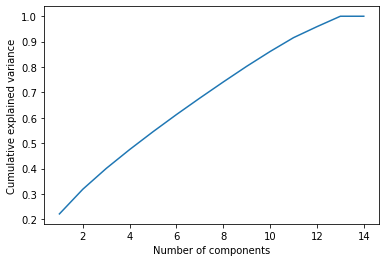

In [11]:
pca = PCA().fit(word_matrix)
plt.plot(np.arange(1,len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [12]:
reduced_data = PCA(n_components=2).fit_transform(word_matrix)

for i, j in zip(cos_sim_df.index, reduced_data):
    print(i, j)

Eric-Adams [0.0489493  4.77139118]
Stacey-Prussman [ 3.48133546 -1.35621898]
Cleopatra-Fitzgerald [ 4.67716823 -0.07114377]
Christopher-S.-Krietchman [-1.12937521 -3.33857414]
Scott-Stringer [-1.79638595  4.1110039 ]
Bill-Pepitone [ 9.86095702 -2.24975972]
Paperboy-Prince [-3.47848272 -3.5149638 ]
Abbey-Laurel-Smith [3.63598343 0.01148282]
Barbara-Kavovit [-6.23078036 -4.65110242]
Maya-Wiley [0.2977922 1.384792 ]
Dianne-Morales [-2.62597398  1.9159168 ]
Joycelyn-Taylor [-4.35759523  0.5156544 ]
Carlos-Menchaca [-0.40709975  0.71499877]
Andrew-Yang [-1.97649245  1.75652297]


In [13]:
source = ColumnDataSource(dict(
    x = reduced_data[:,0],
    y = reduced_data[:,1],
    label = list(cos_sim_df.index)))

tools = ['tap', 'reset', HoverTool(tooltips='@label')]

p = figure(plot_width=700, plot_height=400, tools=tools)

p.circle(x = 'x', y = 'y', legend_field = 'label', size=10, source = source)
p.add_layout(p.legend[0], 'right')
p.legend.click_policy="hide"


# show the results
show(p)